# Population-sensitive travel distance between regions

This notebook aims to calculate travel distances between different regions.
Since the regions are more extensive, we can't just take the center of the area as a starting/ending point: It is essential to know where people are traveling from.
Simplification: We assume that everyone in one region visits another equally often. That means we neglect the effect that border regions visit neighboring regions more frequently than other parts of an origin region. 
Furthermore,  we always route via a particular road near Monte Ceneri since other data (Swisscom) is measured there.

Step by step:
1. Import regions and population density
2. Divide regions into squares with side lengths of 300m
3. Assign squares to regions
4. Calculate the population in squares:
Absolute population and relative population per region
5. select dense squares: Select only the most populated squares per region. Select squares to include 90% of the population.
6. Calculate distance region A --> region B :
   1. Calculate all distances from dense squares in A to dense squares in B
   2. Average distances weighted by the product: relative_population_in_square_A * relative_population_in_square_B.
7. export as csv

## Setup

In [1]:
import json, requests, itertools
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely import wkt
import geopandas as gpd
import contextily as cx
from pandarallel import pandarallel


In [2]:
pandarallel.initialize(progress_bar=False, nb_workers=11)
plt.style.use("bmh")
# plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (16, 9 / 1.5)
plt.rcParams["figure.dpi"] = 300
pd.options.display.max_columns = None


INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Valhalla routing

In [3]:
host = "http://localhost:8002"


def routing_dist(start, via, end, host=host, costing="auto"):
    headers = {"Content-type": "application/json"}
    via["type"] = "via"
    data = json.dumps({"locations": [start, via, end], "costing": costing})
    url = host + "/route"
    routing_request = requests.post(url=url, data=data, headers=headers)
    if routing_request.ok:
        routing_result = routing_request.json()
        return routing_result["trip"]["summary"]["length"], routing_result["trip"]["summary"]["time"]/60
    else:
        raise Exception(routing_request.json())


# test:
Zürich_HB = {"lat": "47.377", "lon": "8.54"}
cividi = {"lat": "47.379467", "lon": "8.553895"}
hsa = {"lat": "47.3835", "lon": "8.4966"}
print("HB --> HSA --> cividi: ~13km ::: ", routing_dist(Zürich_HB, hsa, cividi))
print("HSA --> HB --> cividi: ~ 8km ::: ", routing_dist(hsa, Zürich_HB, cividi))
print("cividi --> HB --> HSA: ~ 8km ::: ", routing_dist(cividi, Zürich_HB, hsa))


HB --> HSA --> cividi: ~13km :::  (12.598, 17.266933333333334)
HSA --> HB --> cividi: ~ 8km :::  (8.703, 11.916566666666666)
cividi --> HB --> HSA: ~ 8km :::  (7.392, 10.777216666666668)


In [4]:
square_sidelength = 300

# 1. Import regions and population density

### POI
define point through which routing should always take place.

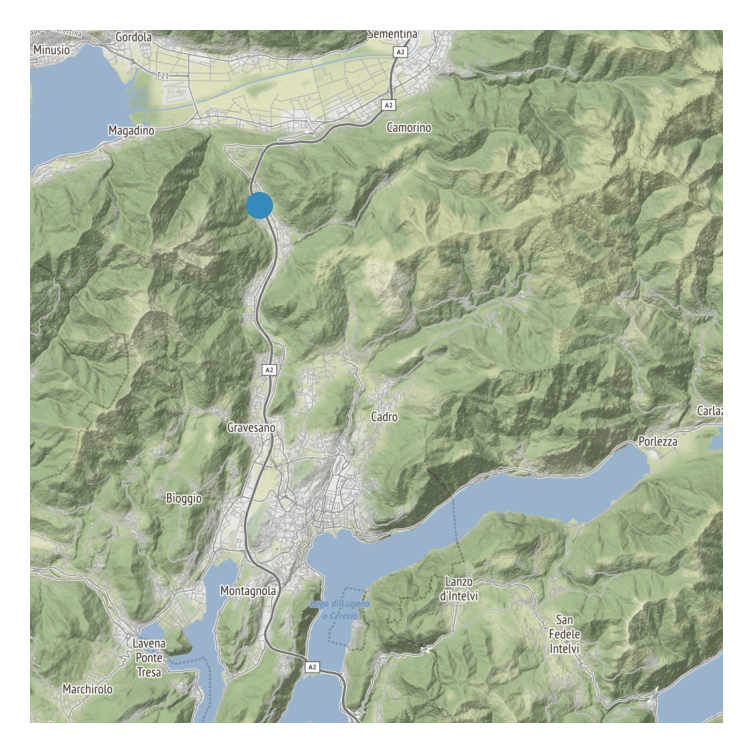

In [5]:
ceneri = {"lat": 46.12179143296322, "lon": 8.922358219416406}
# Visualization
ax = (
    gpd.GeoDataFrame(geometry=[Point(ceneri["lon"], ceneri["lat"])], crs=4326)
    .to_crs(epsg=3857)
    .plot(figsize=(3, 3))
)
plt.ylim(5.77e6, 5.81e6), plt.xlim(0.98e6, 1.02e6)
cx.add_basemap(ax, attribution="")
plt.axis("off");


## Import regions

In [6]:
zones_multiple = gpd.read_file("../_input/OD_Zones.geojson")
print("total: ", len(zones_multiple))
zones_multiple.head(3)


total:  259


objectid  comune_fis  sezione  comune_sez            nome_sezio  \
0       1.0       547.0      0.0     54700.0             GRAVESANO   
1       2.0       553.0      0.0     55300.0              MAGLIASO   
2       3.0       799.0      3.0     79903.0  MONTECENERI-MEDEGLIA   

   comune_fed  comune_f_1  comune_f_2  superficie            nome_sez_1  \
0      5187.0       547.0      5187.0    702049.0             Gravesano   
1      5193.0       553.0      5193.0   1101928.0              Magliaso   
2      5238.0       111.0      5011.0   6300434.0  Monteceneri-Medeglia   

   comune_geo      NomeCIVIDI       title     fill  fill-opacity   stroke  \
0      5187.0  Basso Vedeggio   Gravesano  #4ceda7           0.4  #232323   
1      5193.0      Malcantone    Magliaso  #d1a95e           0.4  #232323   
2      5238.0   Alto Vedeggio  Montecener  #68cebd           0.4  #232323   

   stroke-opacity  stroke-width  \
0             0.4          0.26   
1             0.4          0.26   
2             0.4          0.26   

                                            geometry  
0  MULTIPOLYGON (((8.91367 46.03917, 8.91331 46.0...  
1  MULTIPOLYGON (((8.89360 45.98858, 8.89359 45.9...  
2  MULTIPOLYGON (((8.98574 46.11518, 8.98454 46.1...

union of regions according to Cividi definition

In [7]:
areas = []
for cividi_name in zones_multiple.NomeCIVIDI.unique():
    area = zones_multiple[zones_multiple.NomeCIVIDI == cividi_name].unary_union
    areas.append(area)
zones = gpd.GeoDataFrame(
    {"Name": zones_multiple.NomeCIVIDI.unique()}, geometry=areas, crs=4326
)


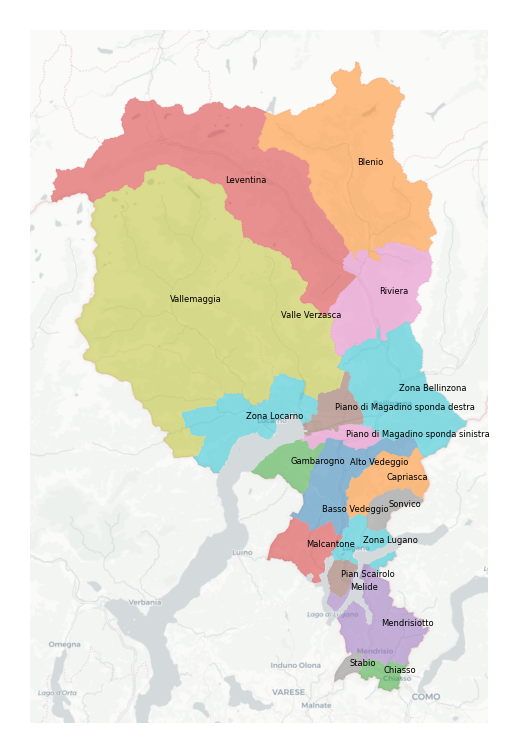

In [8]:
# Visualization
ax = zones.to_crs(epsg=3857).plot("Name", alpha=0.5, figsize=(3, 3))
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution="")
zones.to_crs(epsg=3857).apply(
    lambda x: ax.annotate(text=x["Name"], xy=x.geometry.centroid.coords[0], fontsize=2),
    axis=1,
)
plt.axis("off");


## Load population data

In [9]:
DB_PATH = "/home/sven/Nextcloud/4_Cividi/1_Projekte/_basic_data/BFS.db"


def extract_data(year):
    conn = sqlite3.connect(
        DB_PATH, isolation_level=None, detect_types=sqlite3.PARSE_COLNAMES
    )
    conn.enable_load_extension(True)
    conn.execute('SELECT load_extension("mod_spatialite")')  # all A.B08VZAT
    data = pd.read_sql_query(
        "SELECT A.BTOT, AsText(ST_Transform(A.geometryLV95, 2056)) AS wkt FROM gstatpop as A\
           WHERE yr=='{year}'".format(
            year=year
        ),
        conn,
    )
    return data


pop_lv95wkt = extract_data(2019)


read and cut down to areas

In [10]:
pop = gpd.GeoDataFrame(
    pop_lv95wkt["BTOT"],
    geometry=[wkt.loads(p) for p in pop_lv95wkt["wkt"].values],
    crs=2056,
).to_crs(4326)
print("CH:", "total pop", pop.BTOT.sum(), "; inhabitat hectar", len(pop))
pop = pop[pop.to_crs(2056).intersects(zones.to_crs(2056).buffer(500).unary_union)]
print("All areas:", "total pop", pop.BTOT.sum(), "; inhabitat hectar", len(pop))
pop.sample(3)


CH: total pop 8677554 ; inhabitat hectar 345264
All areas: total pop 355479 ; inhabitat hectar 15887


BTOT                  geometry
257755    29  POINT (8.97536 45.93039)
55858     19  POINT (8.60385 46.34510)
304290     3  POINT (8.95555 46.05302)

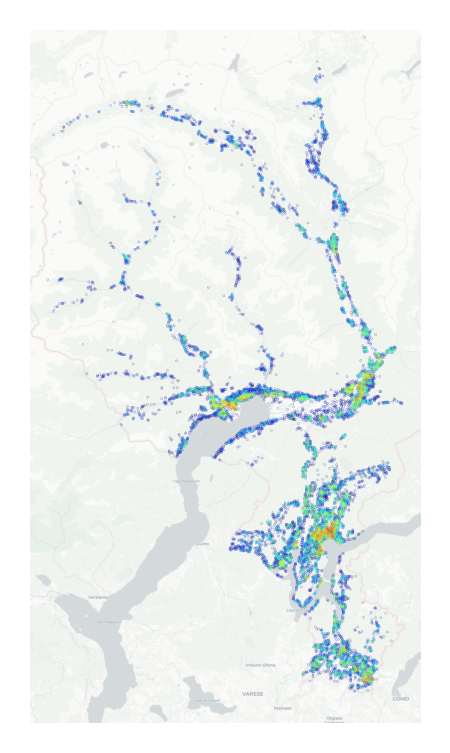

In [11]:
# Visualization
ax = pop.to_crs(epsg=3857).plot(
    "BTOT",
    markersize=0.0015,
    figsize=(3, 3),
    cmap="jet",
    norm=matplotlib.colors.LogNorm(),
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution="")
plt.axis("off");


# 2. Divide regions into squares


In [12]:
total_lat_min, total_lng_min, total_lat_max, total_lng_max = zones.to_crs(2056).total_bounds

squares_geo = []
lat_min = total_lat_min
while lat_min < total_lat_max:
    lng_min = total_lng_min
    while lng_min < total_lng_max:
        square_geo = Polygon(
            (
                (lat_min, lng_min),
                (lat_min + square_sidelength, lng_min),
                (lat_min + square_sidelength, lng_min + square_sidelength),
                (lat_min, lng_min + square_sidelength),
            )
        )
        squares_geo.append(square_geo)
        lng_min += square_sidelength
    lat_min += square_sidelength
squares_geo = gpd.GeoDataFrame(geometry=squares_geo, crs=2056)
squares_geo = squares_geo[squares_geo.intersects(zones.to_crs(2056).unary_union)]
squares_geo = squares_geo.to_crs(4326)
print("Number of squares: ", len(squares_geo))
squares_geo.sample(2)


Number of squares:  31379


geometry
49329  POLYGON ((9.00827 46.09613, 9.01214 46.09607, ...
24268  POLYGON ((8.68665 46.11364, 8.69053 46.11360, ...

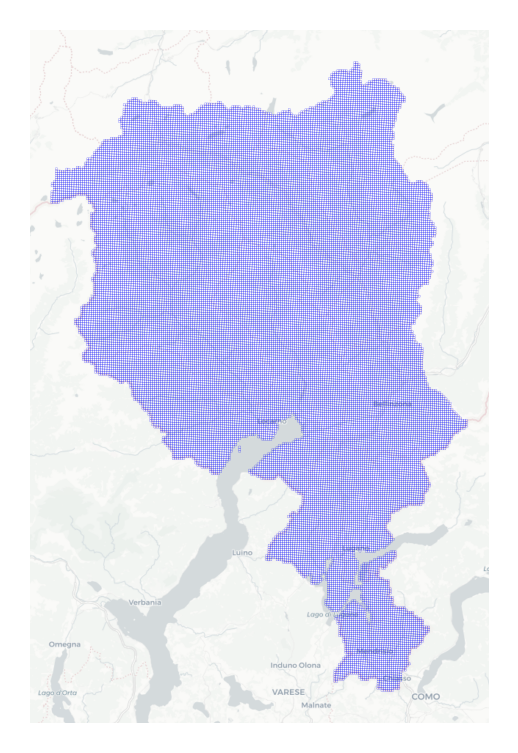

In [13]:
# Visualization
ax = squares_geo.to_crs(epsg=3857).plot(
    facecolor="none", linewidth=0.04, edgecolor="blue", figsize=(3, 3)
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution="")
plt.axis("off");


# 3. Assign squares to regions

In [14]:
squares = gpd.sjoin(squares_geo, zones[["Name", "geometry"]], "left")
squares = squares.drop("index_right", axis=1)
print(len(squares))
squares.sample(2)


33000


geometry             Name
48087  POLYGON ((8.99014 46.00461, 8.99402 46.00455, ...      Zona Lugano
45752  POLYGON ((8.96527 46.22358, 8.96916 46.22353, ...  Zona Bellinzona

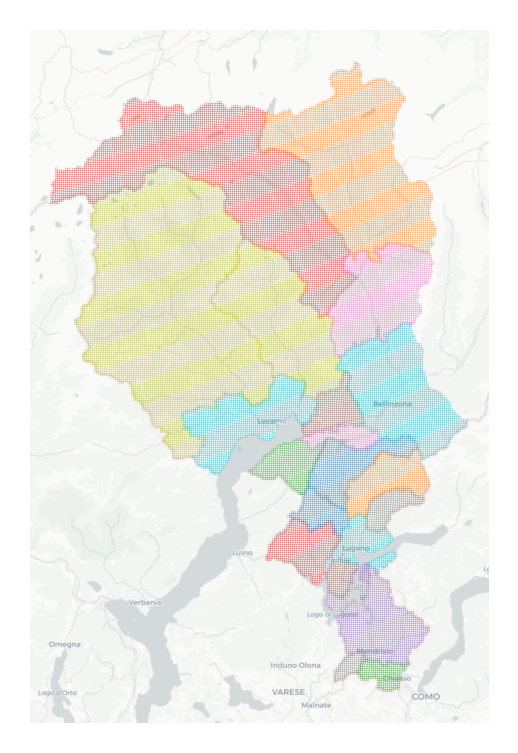

In [15]:
# Visualization
ax = squares.to_crs(epsg=3857).plot("Name", linewidth=0.04, facecolor="none", figsize=(3, 3))
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution="")
plt.axis("off");


# 4. Calculate the population in squares:

Absolute population

In [16]:
%%time
squares['Pop'] = squares.geometry.parallel_apply(lambda geometry: pop.loc[pop.intersects(geometry), 'BTOT'].sum());

/home/sven/miniforge3/envs/ceneri_dist/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val = getattr(super(), mtd)(*args, **kwargs)


CPU times: user 364 ms, sys: 103 ms, total: 467 ms
Wall time: 3min 3s


relative population per region

In [17]:
def calc_pop_representation(row):
    name = row["Name"]
    pop = row["Pop"]
    total_aoi = squares.loc[squares["Name"] == name, "Pop"].sum()
    return pop / total_aoi


In [18]:
squares["Pop_rel"] = squares.parallel_apply(calc_pop_representation, axis=1)
squares.sample(2)


geometry  \
46631  POLYGON ((8.97488 46.15057, 8.97876 46.15052, ...   
11389  POLYGON ((8.52556 46.40409, 8.52946 46.40406, ...   

                                    Name  Pop   Pop_rel  
46631  Piano di Magadino sponda sinistra  175  0.019948  
11389                        Vallemaggia    0  0.000000

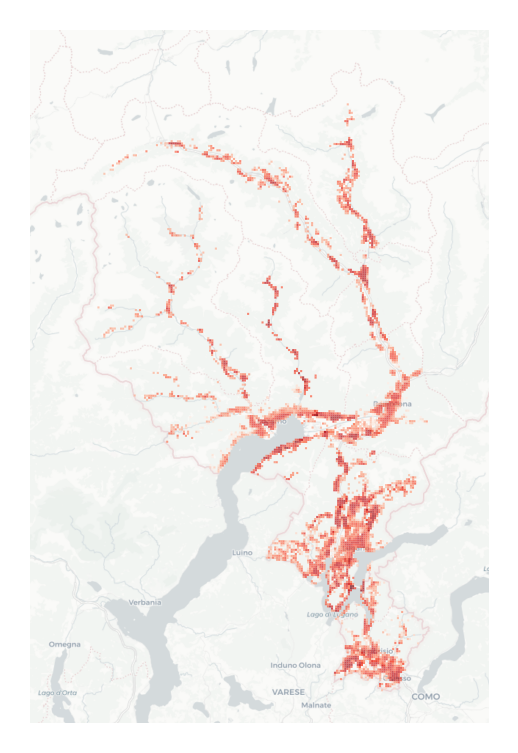

In [19]:
# Visualization
ax = squares.to_crs(epsg=3857).plot(
    "Pop_rel", alpha=0.7, cmap="Reds", norm=matplotlib.colors.LogNorm(), figsize=(3, 3)
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution="")
plt.axis("off");


# 5. select dense squares: 
Select only the most populated squares per region. Select squares to include 90% of the population.
1. For this I sort per region the squares by the relative population size.
2.  calculate a cumulative sum over all squares of a region in the new order.
3.  Then all squares that are above the required maximum representation (90%) can be excluded.


In [20]:
pop_threshold = 0.8


In [21]:
squares = squares.sort_values(by=["Name", "Pop_rel"], ascending=False)
for name in squares.Name.unique():
    squares.loc[squares["Name"] == name, "Pop_rel_cumsum"] = squares.loc[
        squares["Name"] == name, "Pop_rel"
    ].cumsum()
squares.sample(2)


geometry         Name  Pop  \
20796  POLYGON ((8.64919 46.52430, 8.65310 46.52426, ...    Leventina    3   
24916  POLYGON ((8.69715 46.23228, 8.70104 46.23224, ...  Vallemaggia    0   

        Pop_rel  Pop_rel_cumsum  
20796  0.000351        0.975059  
24916  0.000000        1.000000

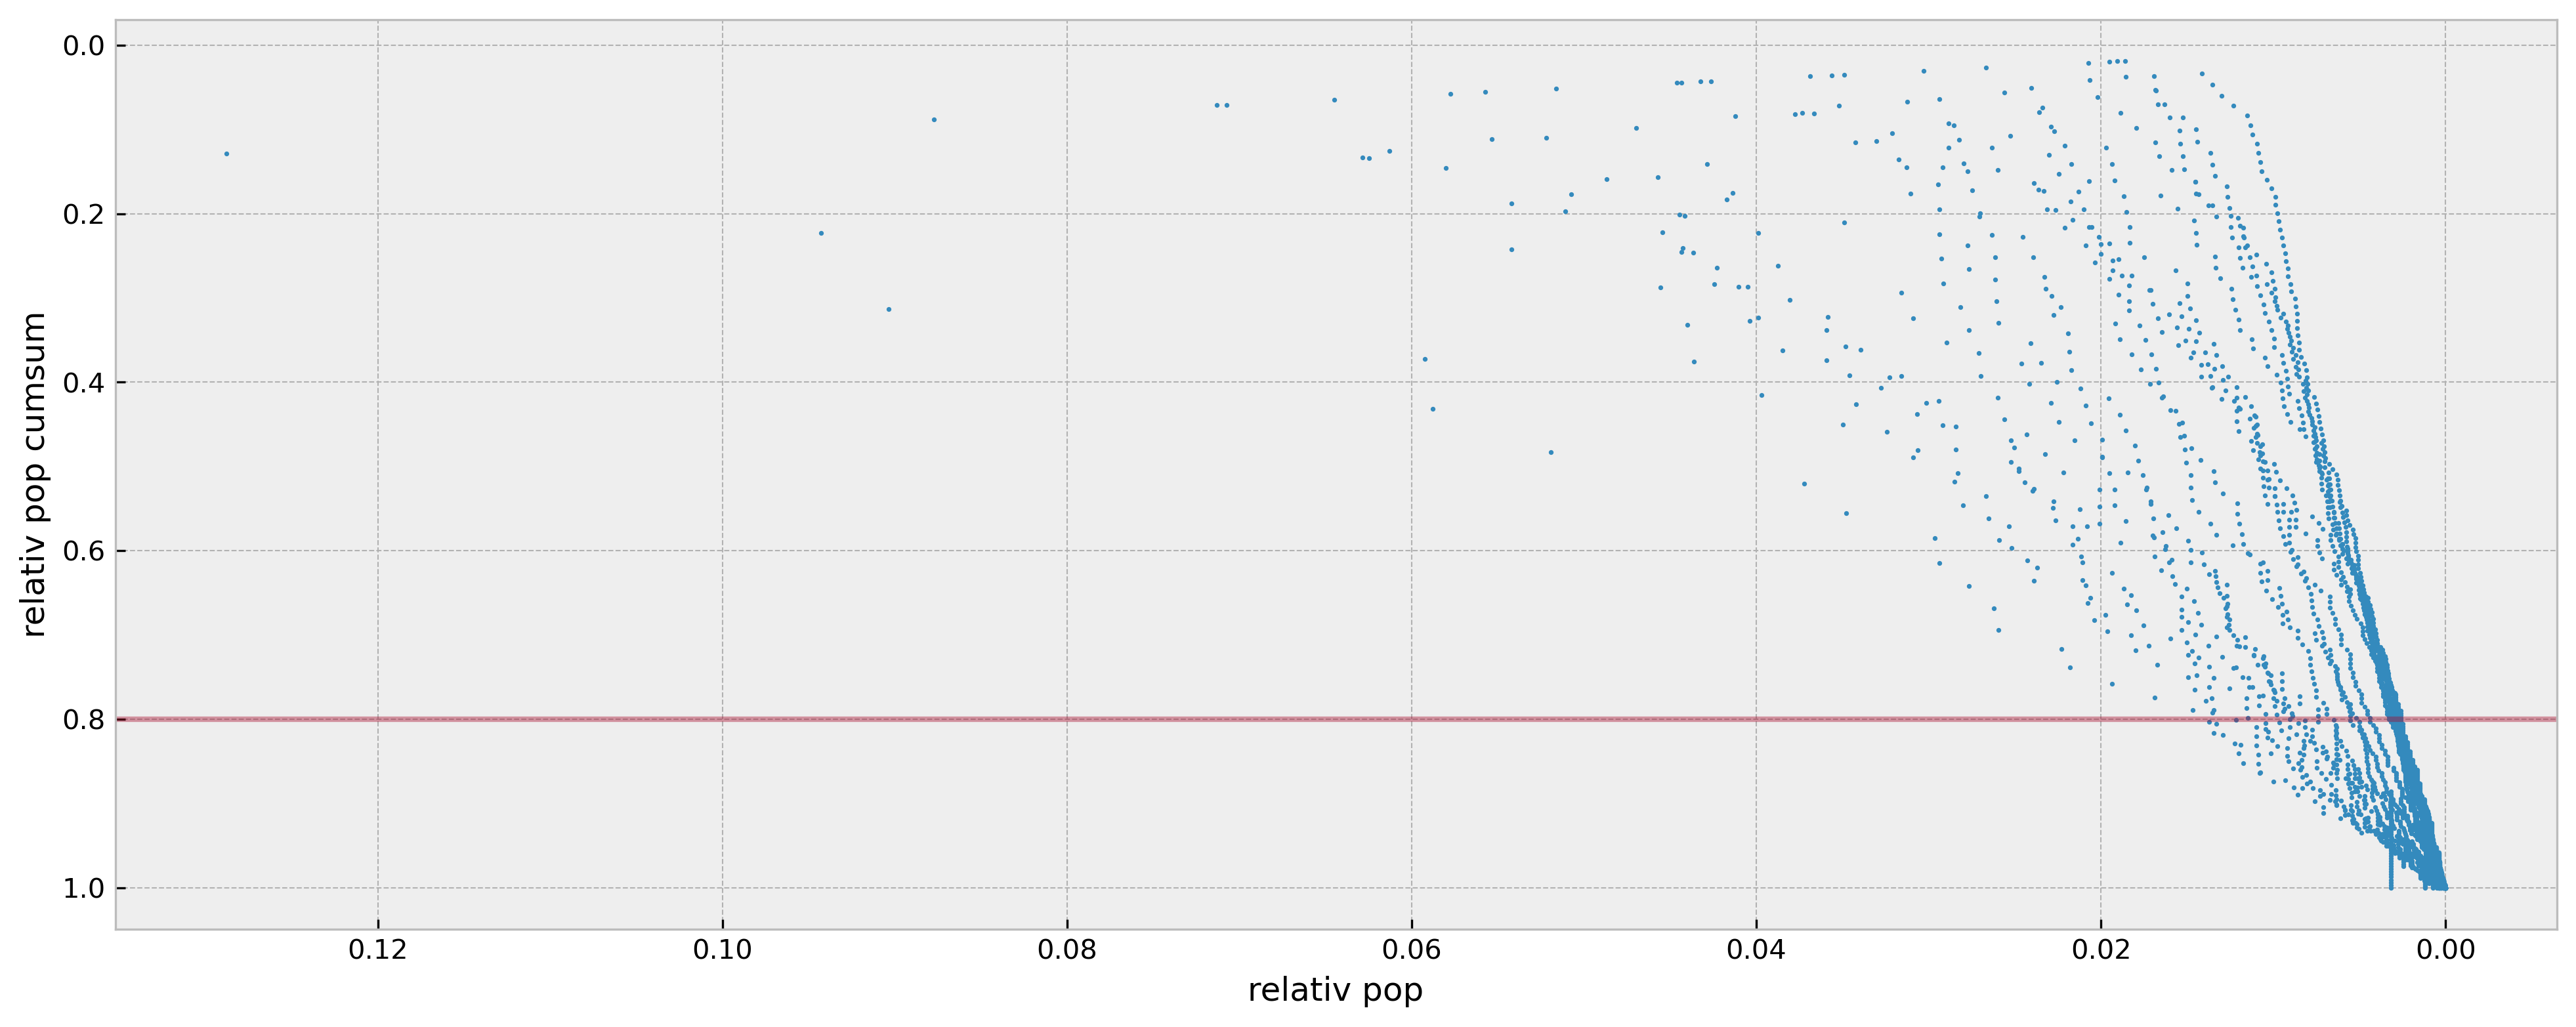

In [22]:
plt.plot(squares.Pop_rel, squares.Pop_rel_cumsum, ".", markersize=1.5)
plt.xlabel("relativ pop"), plt.ylabel("relativ pop cumsum")
plt.xlim(plt.xlim()[::-1])
plt.ylim(plt.ylim()[::-1])
plt.hlines([pop_threshold], *plt.xlim(), colors="C1", alpha=0.4);


In [23]:
squares_selected = squares[squares.Pop_rel_cumsum < pop_threshold]

used_squeres = len(squares_selected) / len(squares) * 100
used_pop = squares_selected.Pop.sum() / squares.Pop.sum() * 100
print(f"We got {int(used_pop)}% of the population respresented in {int(used_squeres)}% of the squares: {len(squares_selected)} squares")


We got 79% of the population respresented in 3% of the squares: 1301 squares


## plot selected sqares

/tmp/ipykernel_413394/1400666809.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  a = gpd.GeoDataFrame(geometry=[Polygon(x.exterior.coords).exterior for x in squares_selected.unary_union],crs=4326)
/tmp/ipykernel_413394/1400666809.py:5: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  b = gpd.GeoDataFrame(geometry=[Polygon(x.exterior.coords).exterior for x in squares[squares.Pop > 0].unary_union],crs=4326,)


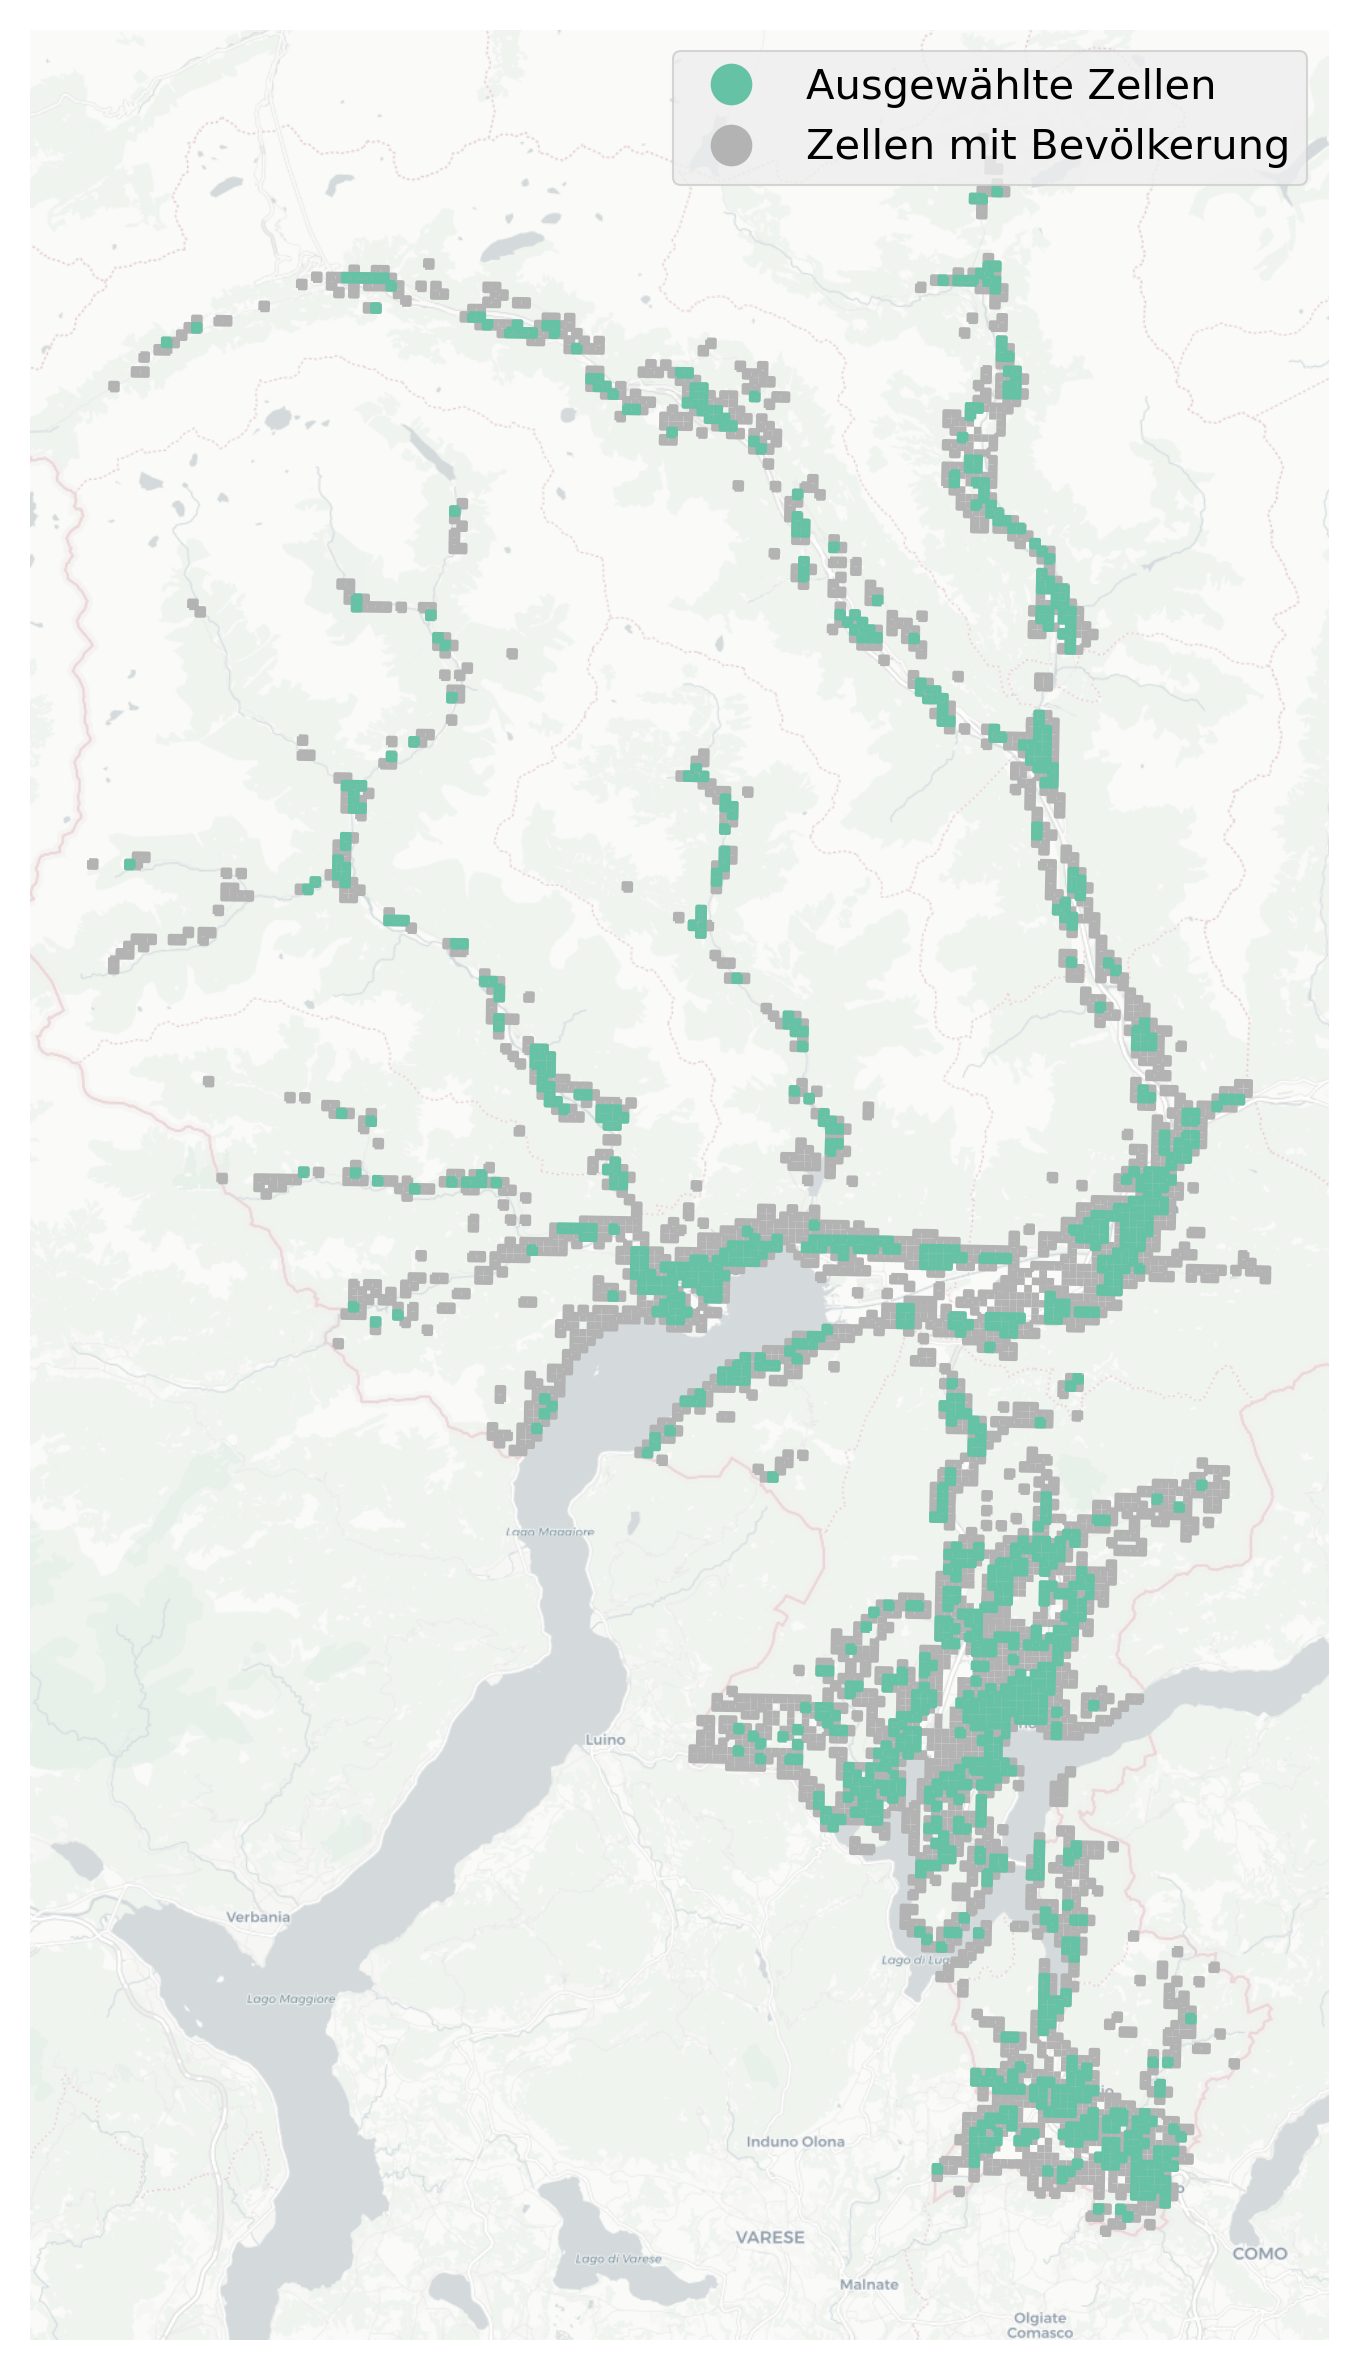

In [24]:
a = gpd.GeoDataFrame(geometry=[Polygon(x.exterior.coords).exterior for x in squares_selected.unary_union],crs=4326)
a = pd.concat([a, squares_selected])
a['Beschreibung'] = 'Ausgewählte Zellen'

b = gpd.GeoDataFrame(geometry=[Polygon(x.exterior.coords).exterior for x in squares[squares.Pop > 0].unary_union],crs=4326,)
b = pd.concat([b, squares[squares.Pop > 0]])
b['Beschreibung'] = 'Zellen mit Bevölkerung'

c = pd.concat([a,b])
c = c.sort_values('Beschreibung',ascending=False)

ax = c.to_crs(epsg=3857).plot(
    "Beschreibung",
    cmap='Set2',
    legend=3,
    linewidth=1,
    figsize=(10,10),
)
cx.add_basemap(
    ax, source=cx.providers.CartoDB.Positron, attribution=""
)
plt.axis('off')
plt.savefig(
    f"../_output/Zellenauswahl.png",
    transparent=False,
    facecolor="white",
    bbox_inches="tight",
)


# 6. Calculate distance region 
A --> region B :
   1. Calculate all distances from dense squares in A to dense squares in B
   2. Average distances weighted by the product: relative_population_in_square_A * relative_population_in_square_B.

In [26]:
def weighted_average_normalized(distribution, weights):

    numerator = sum([distribution[i] * weights[i] for i in range(len(distribution))])
    denominator = sum(weights)

    return round(numerator / denominator, 2)

weighted_average_normalized([0, 10, 10], [0.2, 0.2, 0.2])


6.67

### example: from Chiasso without ceneri

In [27]:
od_name_combinations_Chiasso = [("Chiasso", a) for a in squares.Name.unique()]
od_name_combinations_Chiasso.append(("Chiasso", "Chiasso"))
print("Number of combinations: ", len(od_name_combinations_Chiasso))
od_name_combinations_Chiasso[:3]


Number of combinations:  22


[('Chiasso', 'Zona Lugano'),
 ('Chiasso', 'Zona Locarno'),
 ('Chiasso', 'Zona Bellinzona')]

In [28]:
averages_time, averages_dist = [], []
for origin, destianation in tqdm(od_name_combinations_Chiasso):
    origin_squares = squares_selected[squares_selected.Name == origin]
    destianation_squares = squares_selected[squares_selected.Name == destianation]
    od_combinations_to_calc = []
    for _, ori_row in origin_squares.iterrows():
        for _, dest_row in destianation_squares.iterrows():
            od_combination = {
                "ori_loc": {
                    "lat": ori_row.geometry.centroid.y,
                    "lon": ori_row.geometry.centroid.x,
                },
                "dest_loc": {
                    "lat": dest_row.geometry.centroid.y,
                    "lon": dest_row.geometry.centroid.x,
                },
                "pop_rel_product": ori_row.Pop_rel * dest_row.Pop_rel,
            }
            od_combinations_to_calc.append(od_combination)
    od_combinations_to_calc = pd.DataFrame(od_combinations_to_calc)
    od_combinations_to_calc[["distance", "time"]] = od_combinations_to_calc.parallel_apply(
        lambda row: routing_dist(row.ori_loc, row.ori_loc, row.dest_loc), axis=1
    ).tolist()
    average_distance = weighted_average_normalized(
        od_combinations_to_calc.distance, od_combinations_to_calc.pop_rel_product
    )
    averages_dist.append(average_distance)
    average_time = weighted_average_normalized(
        od_combinations_to_calc.time, od_combinations_to_calc.pop_rel_product
    )
    averages_time.append(average_time)

distances_chia = pd.DataFrame(
    {
        "origin": [l[0] for l in od_name_combinations_Chiasso],
        "destination": [l[1] for l in od_name_combinations_Chiasso],
        "dist": averages_dist,
    }
)
times_chia = pd.DataFrame(
    {
        "origin": [l[0] for l in od_name_combinations_Chiasso],
        "destination": [l[1] for l in od_name_combinations_Chiasso],
        "time": averages_time,
    }
)


100%|██████████| 22/22 [05:23<00:00, 14.71s/it]


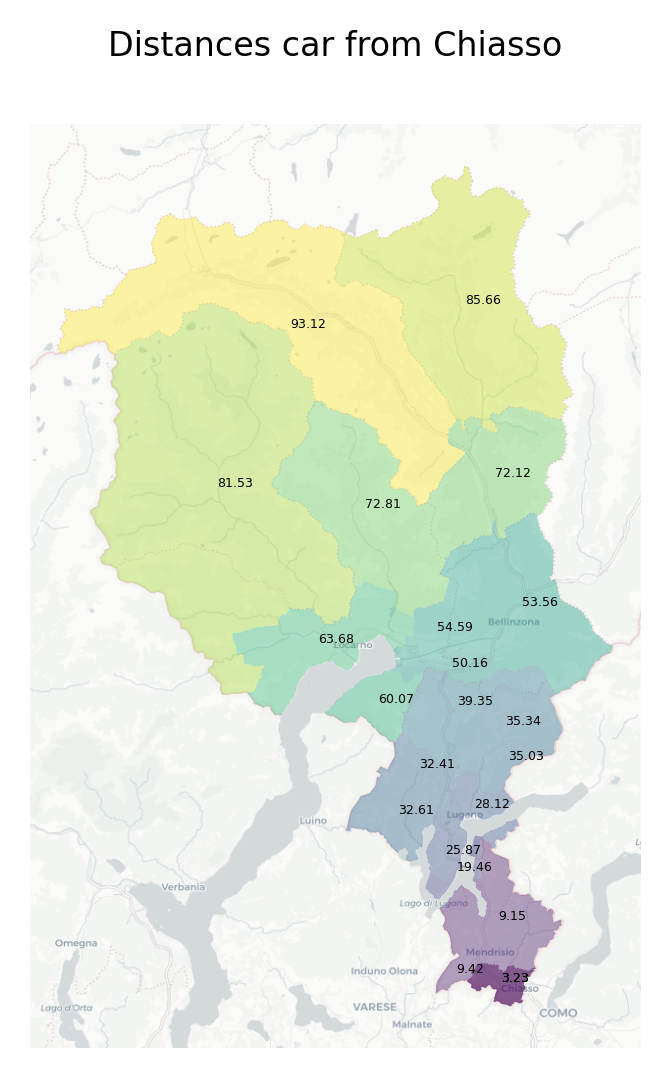

In [39]:
chia_gpd = gpd.GeoDataFrame(
    pd.merge(distances_chia, zones, left_on="destination", right_on="Name")
)
chia_gpd = chia_gpd.drop("Name", axis=1)

# Visualization
ax = chia_gpd.to_crs(epsg=3857).plot("dist", alpha=0.4, figsize=(4, 4))
chia_gpd.to_crs(epsg=3857).apply(
    lambda x: ax.annotate(text=x["dist"], xy=x.geometry.centroid.coords[0], fontsize=3),
    axis=1,
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution="")
plt.title("Distances car from Chiasso", fontdict={"size": 8})
plt.axis("off")
plt.savefig(f'../tests/car_distances_from_Chiasso_without_ceneri.png', transparent=False, facecolor='white', bbox_inches='tight');
m = chia_gpd.explore("dist", tiles="CartoDB positron")
m.save(f"../tests/car_distances_from_Chiasso_without_ceneri.html")

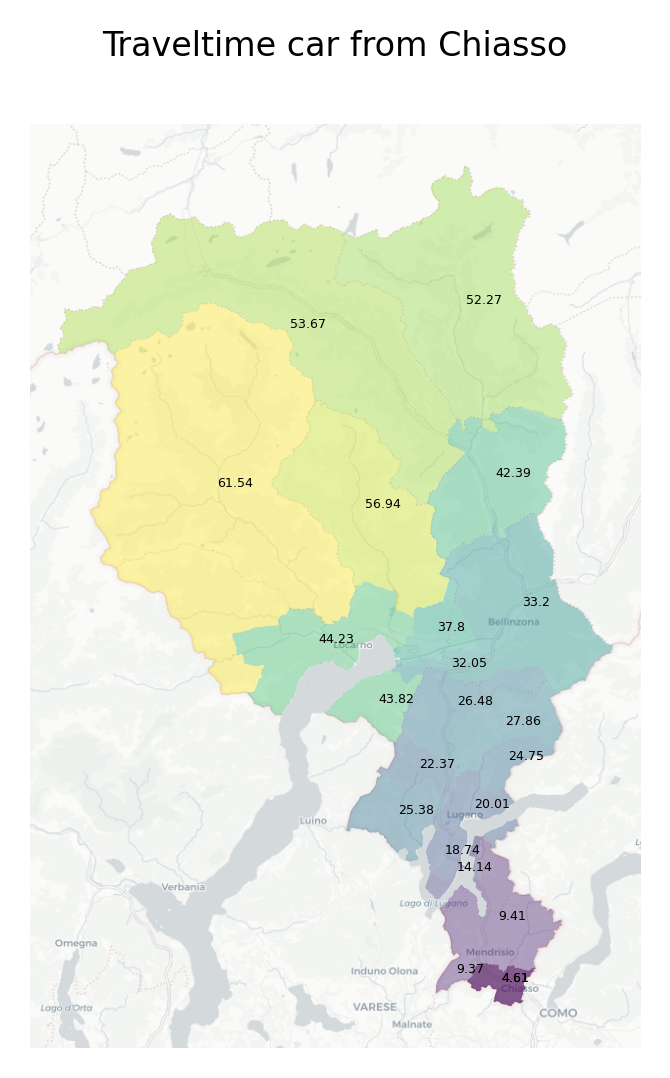

In [38]:
chia_gpd = gpd.GeoDataFrame(
    pd.merge(times_chia, zones, left_on="destination", right_on="Name")
)
chia_gpd = chia_gpd.drop("Name", axis=1)

# Visualization
ax = chia_gpd.to_crs(epsg=3857).plot("time", alpha=0.4, figsize=(4, 4))
chia_gpd.to_crs(epsg=3857).apply(
    lambda x: ax.annotate(text=x["time"], xy=x.geometry.centroid.coords[0], fontsize=3),
    axis=1,
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution="")
plt.title("Traveltime car from Chiasso", fontdict={"size": 8})
plt.axis("off")
plt.savefig(f'../tests/car_time_from_Chiasso_without_ceneri.png', transparent=False, facecolor='white', bbox_inches='tight');
m = chia_gpd.explore("time", tiles="CartoDB positron")
m.save(f"../tests/car_time_from_Chiasso_without_ceneri.html")


### all regions to all regions with ceneri 

In [32]:
od_name_combinations = list(itertools.permutations(squares.Name.unique(), 2))
od_name_combinations.extend((name, name) for name in squares.Name.unique())
print("Number of combinations: ", len(od_name_combinations))
od_name_combinations[:3]


Number of combinations:  441


[('Zona Lugano', 'Zona Locarno'),
 ('Zona Lugano', 'Zona Bellinzona'),
 ('Zona Lugano', 'Vallemaggia')]

In [33]:
averages_time, averages_dist = [], []
for origin, destianation in tqdm(od_name_combinations):
    origin_squares = squares_selected[squares_selected.Name == origin]
    destianation_squares = squares_selected[squares_selected.Name == destianation]
    od_combinations_to_calc = []
    for _, ori_row in origin_squares.iterrows():
        for _, dest_row in destianation_squares.iterrows():
            od_combination = {
                "ori_loc": {
                    "lat": ori_row.geometry.centroid.y,
                    "lon": ori_row.geometry.centroid.x,
                },
                "dest_loc": {
                    "lat": dest_row.geometry.centroid.y,
                    "lon": dest_row.geometry.centroid.x,
                },
                "pop_rel_product": ori_row.Pop_rel * dest_row.Pop_rel,
            }
            od_combinations_to_calc.append(od_combination)
    od_combinations_to_calc = pd.DataFrame(od_combinations_to_calc)
    od_combinations_to_calc[["distance", "time"]] = od_combinations_to_calc.parallel_apply(
        lambda row: routing_dist(row.ori_loc, ceneri, row.dest_loc), axis=1
    ).tolist()
    average_distance = weighted_average_normalized(
        od_combinations_to_calc.distance, od_combinations_to_calc.pop_rel_product
    )
    averages_dist.append(average_distance)
    average_time = weighted_average_normalized(
        od_combinations_to_calc.time, od_combinations_to_calc.pop_rel_product
    )
    averages_time.append(average_time)

distances = pd.DataFrame(
    {
        "origin": [l[0] for l in od_name_combinations],
        "destination": [l[1] for l in od_name_combinations],
        "dist": averages_dist,
    }
)
times = pd.DataFrame(
    {
        "origin": [l[0] for l in od_name_combinations],
        "destination": [l[1] for l in od_name_combinations],
        "time": averages_time,
    }
)



100%|██████████| 441/441 [2:17:22<00:00, 18.69s/it]  


## visualization

/tmp/ipykernel_135658/2501895999.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_135658/2501895999.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c_d = lambda zna, znb: distances[distances.origin == zna][


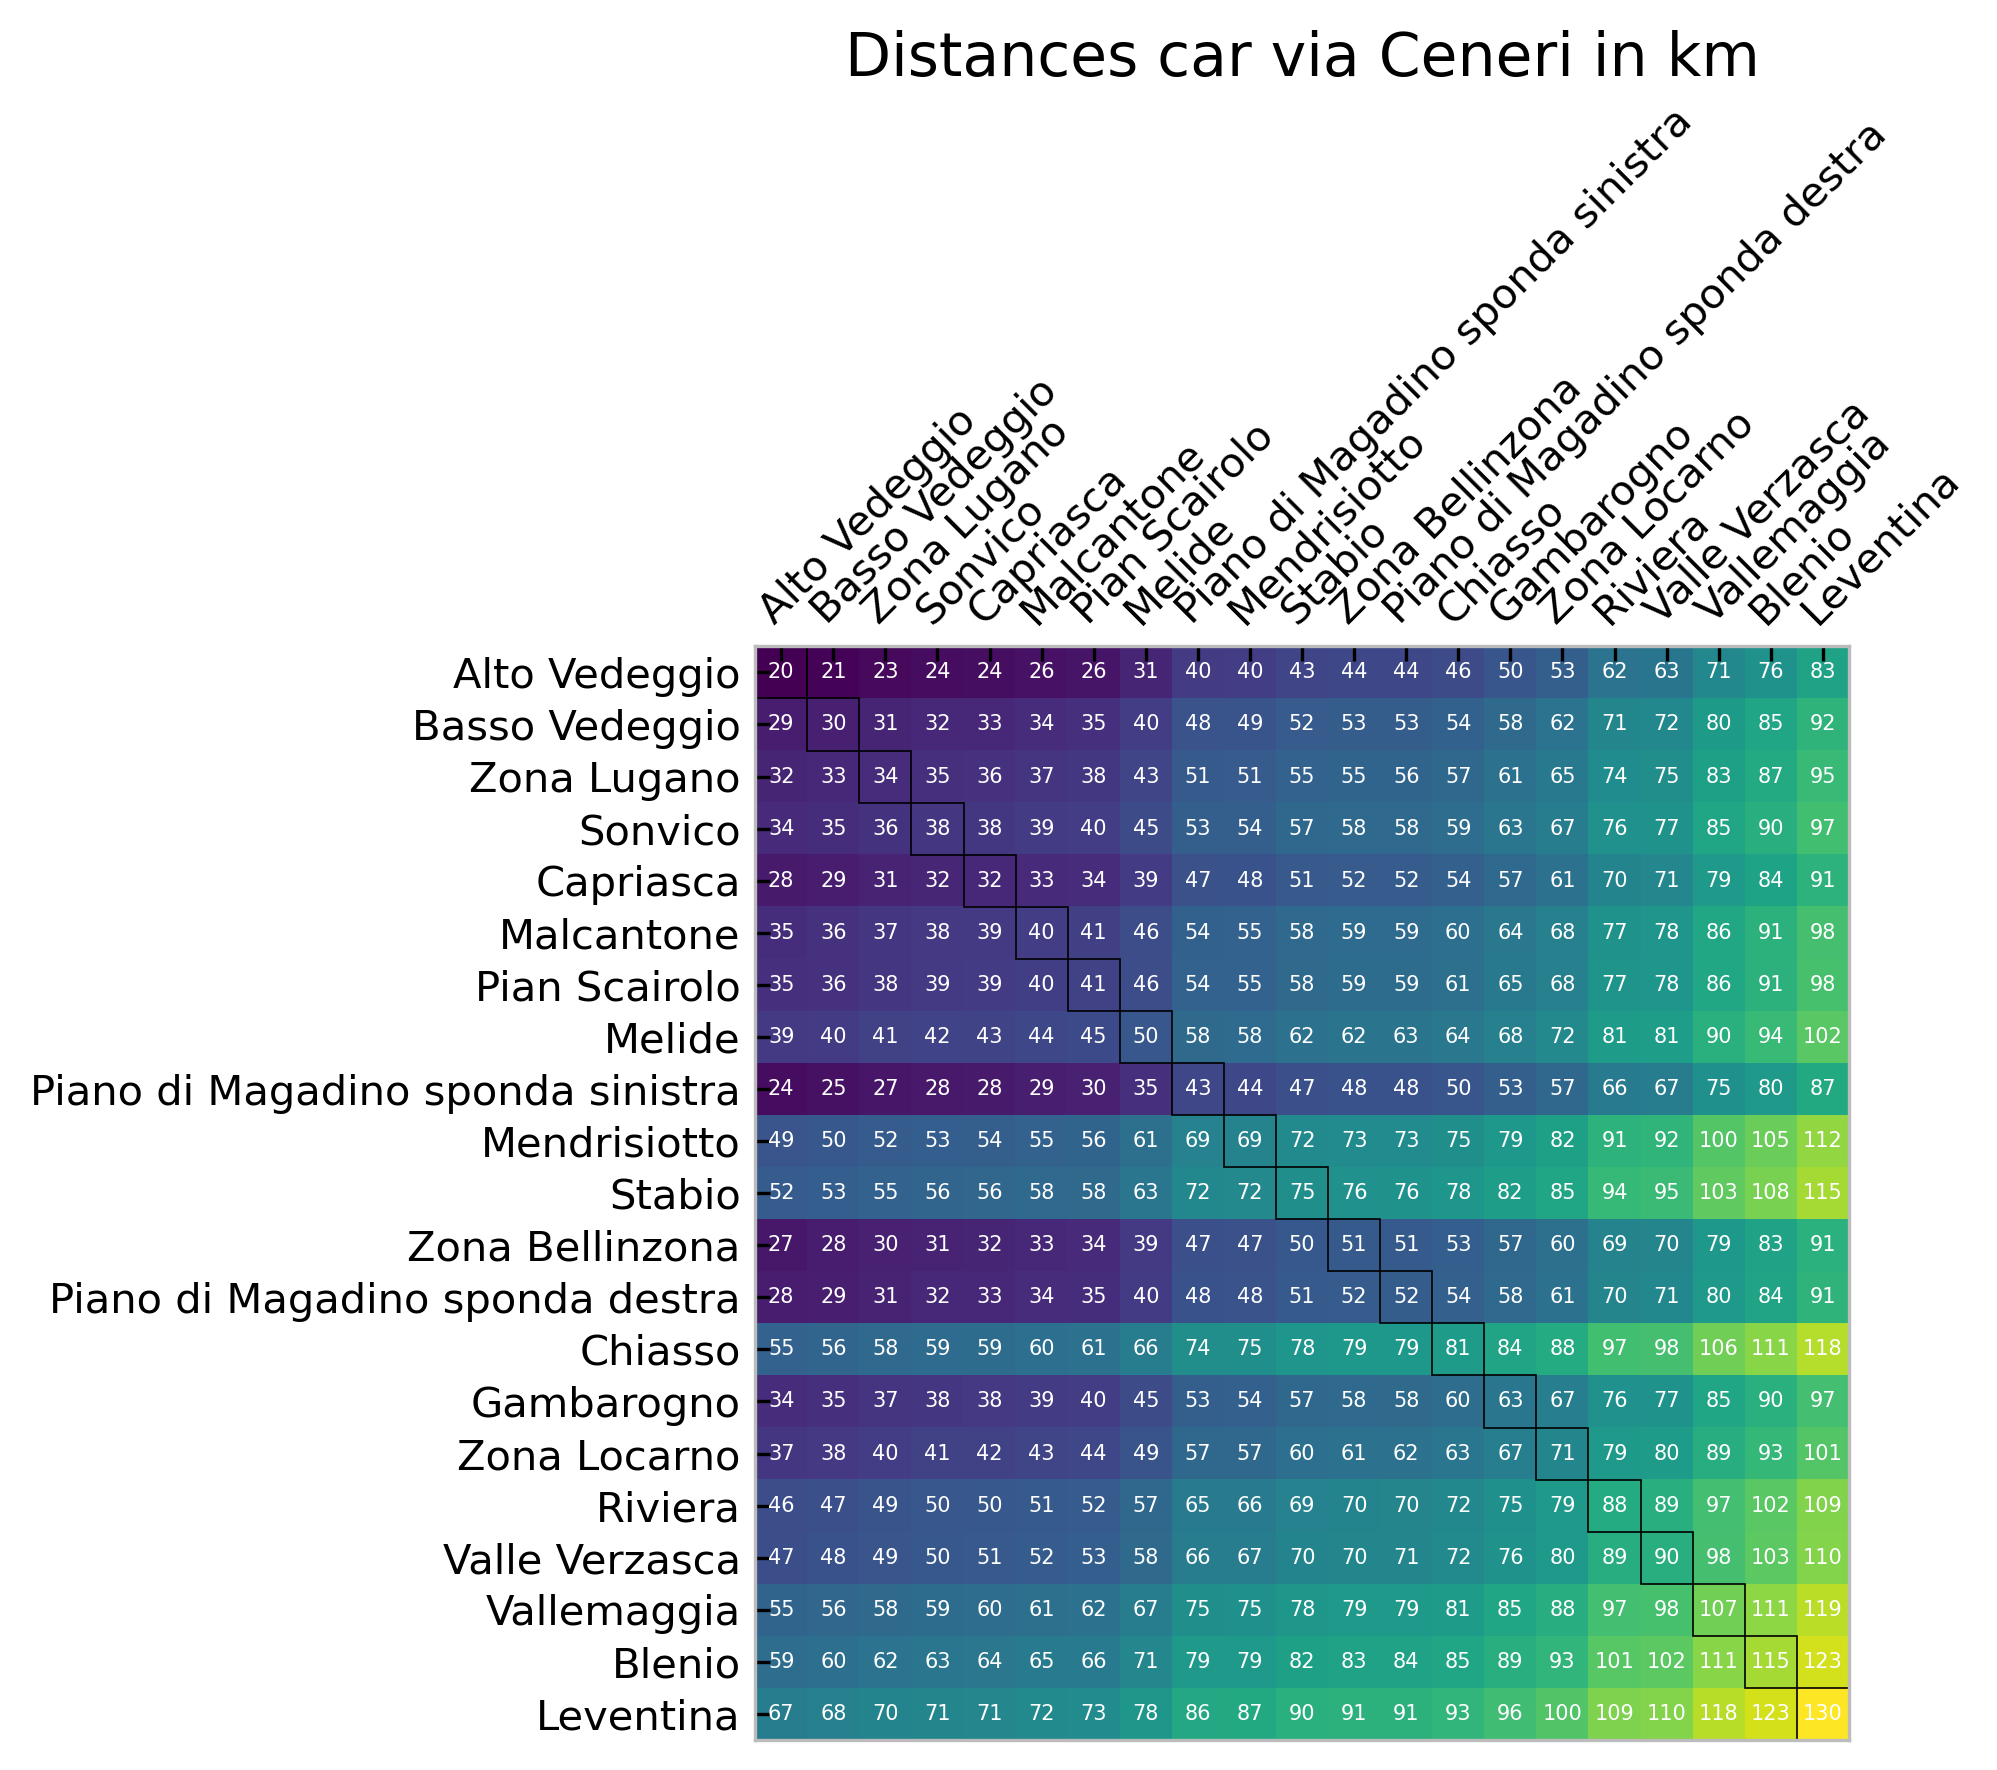

In [34]:
zone_names = (
    distances.groupby("origin")
    .mean()
    .sort_values("dist")
    .reset_index()["origin"]
    .to_list()
)
c_d = lambda zna, znb: distances[distances.origin == zna][
    distances.destination == znb
].dist.values[0]
a = c_d(zone_names[0], zone_names[0])
x_names = zone_names[:]
y_names = zone_names[:]
dist_matrix = [[c_d(zna, znb) for zna in x_names] for znb in y_names]

fig, ax = plt.subplots()
im = ax.imshow(dist_matrix)
ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)
plt.grid(None)
# Rotate the tick labels and set their alignment.
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(
            j,
            i,
            int(np.array(dist_matrix)[i, j]),
            ha="center",
            va="center",
            color="w",
            fontdict={"size": 5},
        )


def highlight_cell(x, y, ax=None, **kwargs):
    rect = plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


for pos in range(len(x_names)):
    highlight_cell(pos, pos, color="k", linewidth=0.4)
plt.title('Distances car via Ceneri in km')
fig.tight_layout()
plt.savefig(f'../tests/car_distances.png', transparent=False, facecolor='white', bbox_inches='tight');
plt.show()


/tmp/ipykernel_135658/194187474.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_135658/194187474.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c_d = lambda zna, znb: times[times.origin == zna][


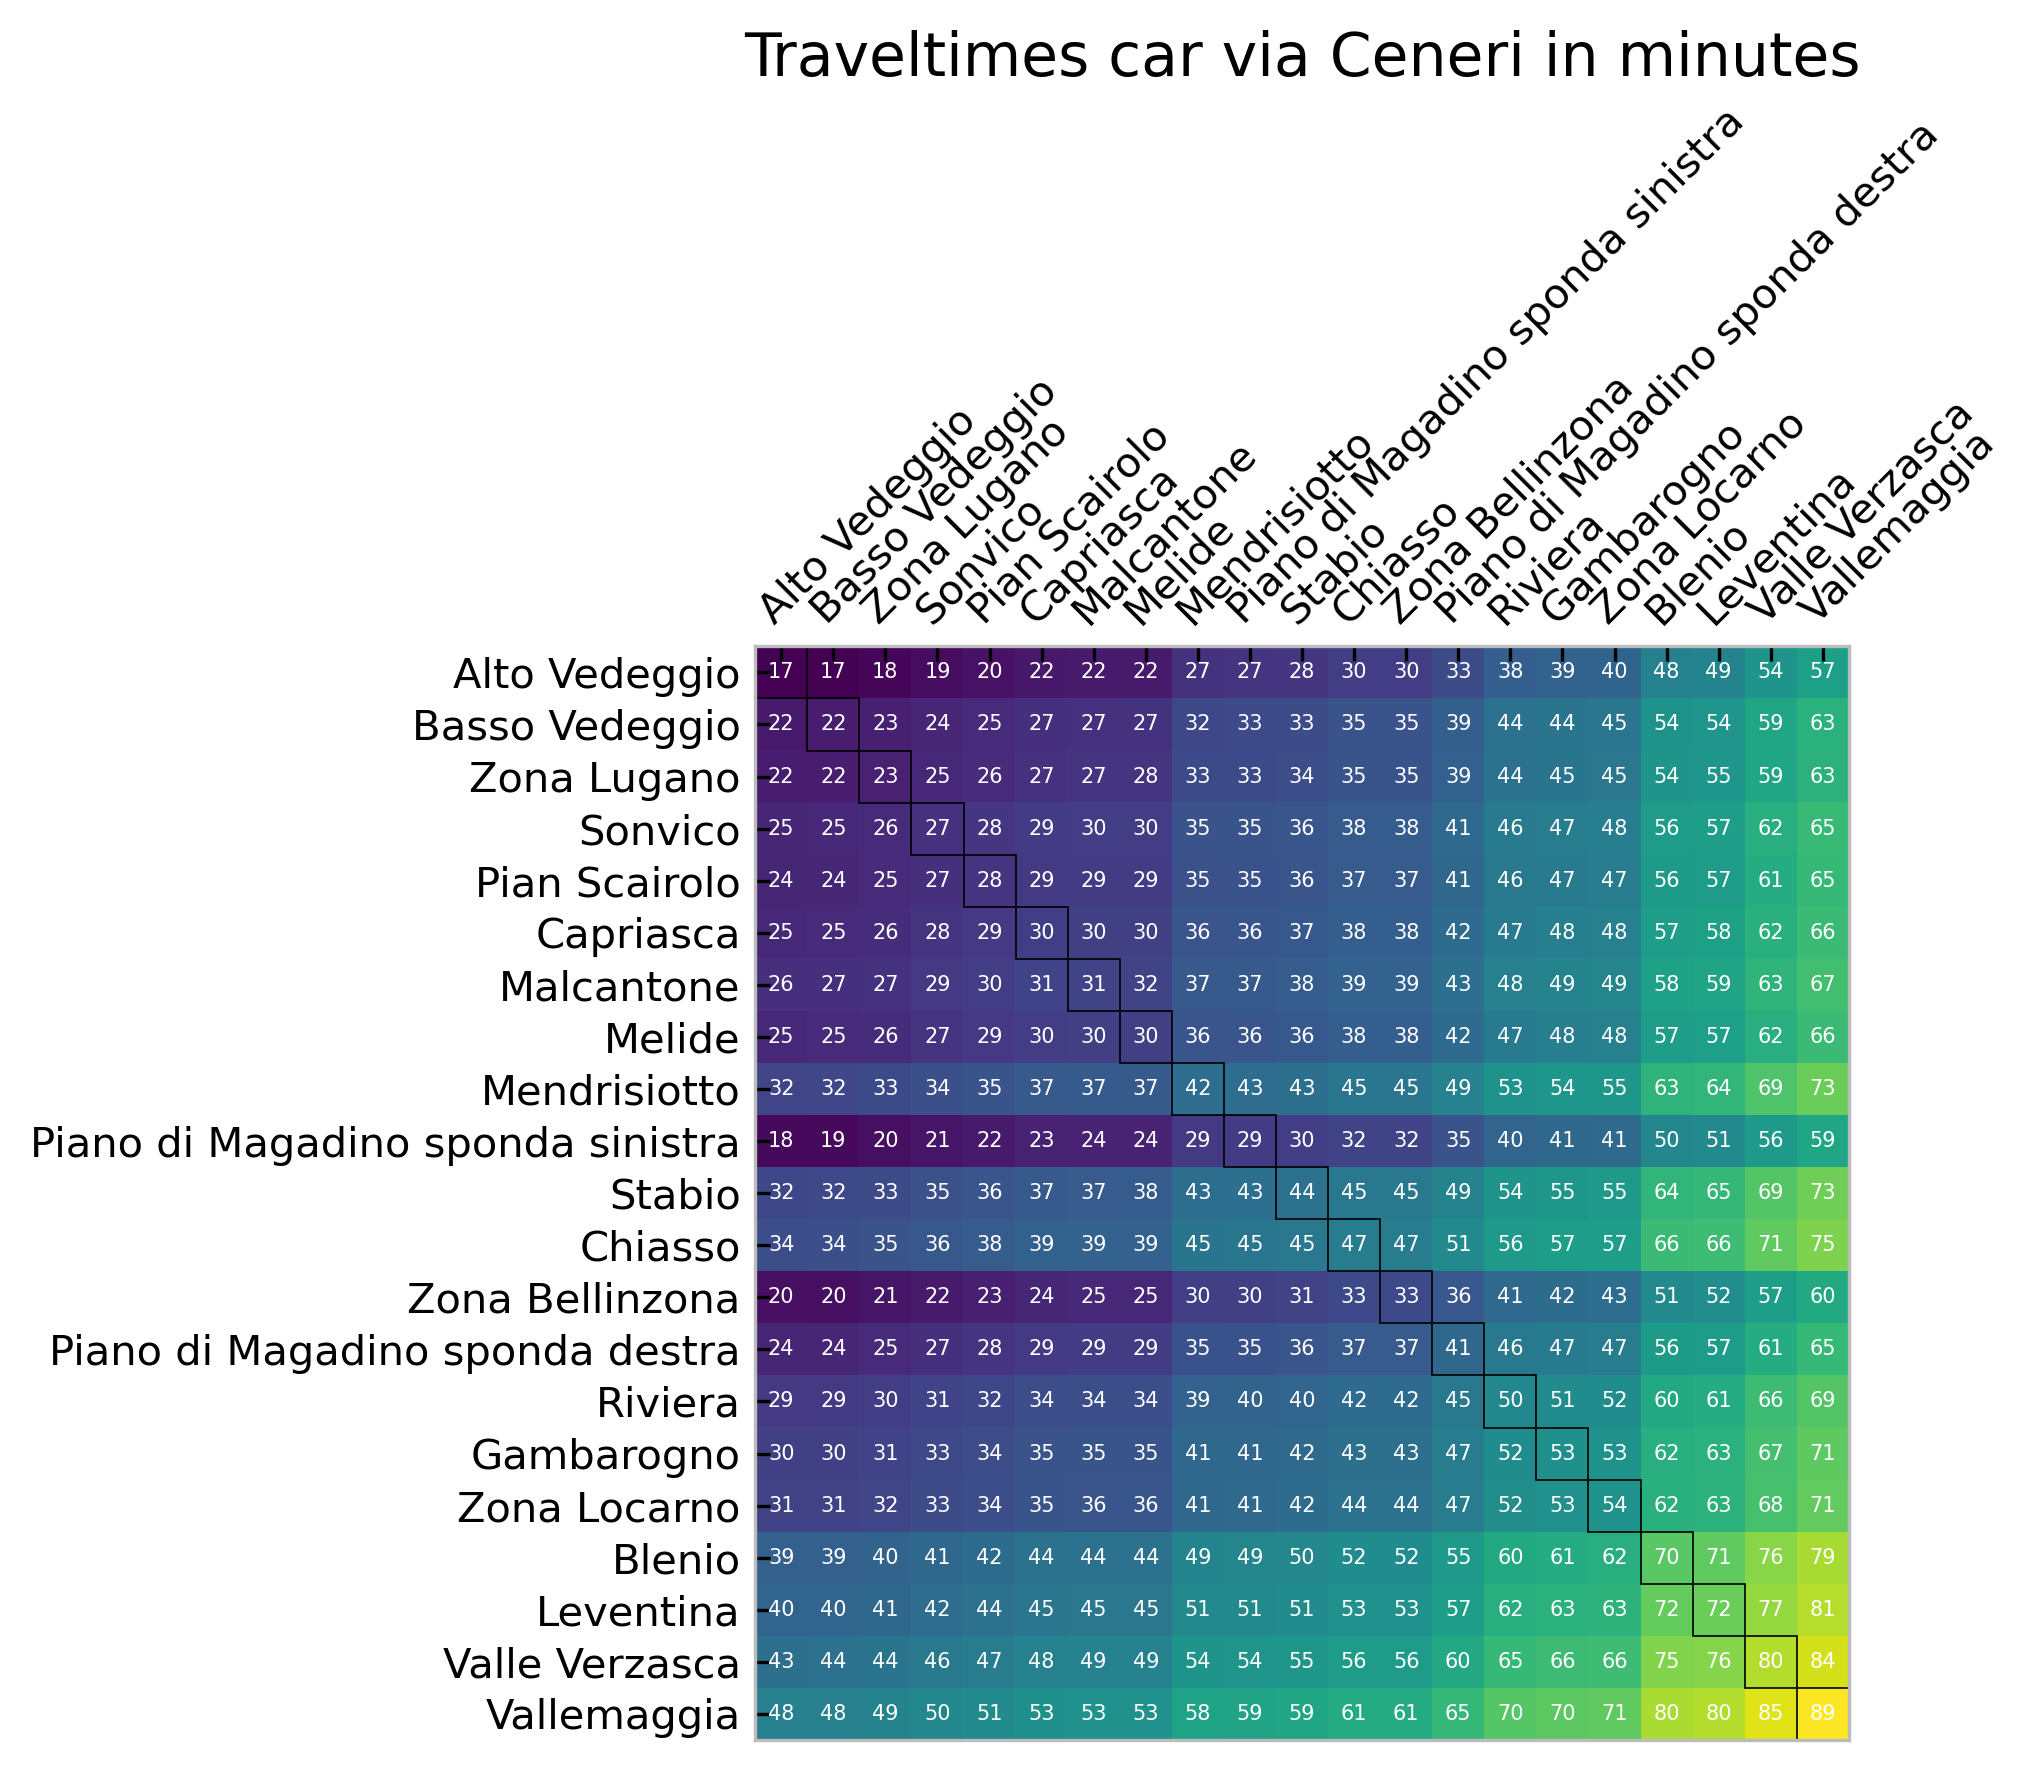

In [35]:
zone_names = (
    times.groupby("origin")
    .mean()
    .sort_values("time")
    .reset_index()["origin"]
    .to_list()
)
c_d = lambda zna, znb: times[times.origin == zna][
    times.destination == znb
].time.values[0]
a = c_d(zone_names[0], zone_names[0])
x_names = zone_names[:]
y_names = zone_names[:]
dist_matrix = [[c_d(zna, znb) for zna in x_names] for znb in y_names]

fig, ax = plt.subplots()
im = ax.imshow(dist_matrix)
ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)
plt.grid(None)
# Rotate the tick labels and set their alignment.
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(
            j,
            i,
            int(np.array(dist_matrix)[i, j]),
            ha="center",
            va="center",
            color="w",
            fontdict={"size": 5},
        )


def highlight_cell(x, y, ax=None, **kwargs):
    rect = plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


for pos in range(len(x_names)):
    highlight_cell(pos, pos, color="k", linewidth=0.4)
plt.title('Traveltimes car via Ceneri in minutes')
fig.tight_layout()
plt.savefig(f'../tests/car_times.png', transparent=False, facecolor='white', bbox_inches='tight');
plt.show()


# export as csv

In [37]:
distances.to_csv(f"../_output/car_distances.csv", index=False)
times.to_csv(f"../_output/car_times.csv", index=False)
